# Merge ODHF with LTC data for Coordinate information

---

In [1]:
import numpy as np
import pandas as pd

In [29]:
ltc = pd.read_csv('../data/BC/seniorsadv_data.csv')
odhf = pd.read_excel('../data/BC/odhf_ltc.xlsx')

In [30]:
ltc['facility_name'] = ltc['FACILITY_NAME'].str.lower()

In [31]:
merge = pd.merge(ltc, odhf, on = 'facility_name', how = 'left')

In [35]:
merge.head()
merge.columns

Index(['HCC_CODE', 'FACILITY_NAME', 'HLTH_AUTH', 'OWNERSHIP', 'STREET_ADDRESS',
       'CITY', 'POSTAL', 'PHONE', 'OPERATOR_NAME', 'OPEN_DATE',
       ...
       'street_name', 'postal_code', 'city', 'province',
       'source_format_str_address', 'CSDname', 'CSDuid', 'Pruid', 'latitude',
       'longitude'],
      dtype='object', length=118)

#### Fill lat/lon NAs with BC Gov Data -- <mark> SAME LTCS ARE MISSING VALUES </mark>

In [6]:
# bcgov = pd.read_csv('../data/gsr_residential_care.csv')
# bcgov_ltc = bcgov.loc[bcgov.LONG_TERM_CARE == 'Y']

# dr_cols = ['TYPE', 'STREET_ADDRESS', 'CITY', 'INSPECTION_URL',
#           'GOVERNING_REGULATION', 'HEALTH_AUTHORITY', 'MENTAL_HEALTH',
#        'MENTAL_HEALTH_MAX_CAP', 'HOSPICE', 'HOSPICE_MAX_CAP', 'SUBSTANCE_USE',
#        'SUBSTANCE_USE_MAX_CAP', 'LONG_TERM_CARE', 'LONG_TERM_CARE_MAX_CAP',
#        'COMMUNITY_LIVING', 'COMMUNITY_LIVING_MAX_CAP', 'ACQUIRED_BRAIN_INJURY',
#        'ACQUIRED_BRAIN_INJURY_MAX_CAP']
# bcgov_ltc.drop(columns = dr_cols, inplace = True)



In [7]:
# # merge on postal code
# def rm_space(x):
#     return x.replace(' ','')

# bcgov_ltc['POSTAL'] = bcgov_ltc.POSTAL_CODE.map(rm_space)

# complete = pd.merge(merge, bcgov_ltc, on = 'POSTAL', how = 'outer')

# complete.info()

In [8]:
# complete.latitude.fillna(complete['LATITUDE'], inplace = True)
# complete.longitude.fillna(complete['LONGITUDE'], inplace = True)

### Geocode Leftover Nulls

In [36]:
from geopy import *
import geopandas

In [37]:
locator = Nominatim(user_agent="myGeocoder")

In [38]:
# reformat address to be one string
address = []
for s,c in zip(merge['STREET_ADDRESS'].to_list(), merge['CITY'].to_list()):
        address.append("{}, {}, British Columbia, Canada".format(s,c))
        
merge['address'] = address
merge.address

0      1450 Hillside Ave., Victoria, British Columbia...
1      2655 E Shawnigan Lake Rd, Shawnigan Lake, Brit...
2      1325 Summit Avenue, Prince Rupert, British Col...
3      851 Boundary Road, Vancouver, British Columbia...
4      1525 MacKay Crescent, Agassiz, British Columbi...
                             ...                        
292    2510 West Hwy 62, Hazelton, British Columbia, ...
293    1099 Cambie Street, Vancouver, British Columbi...
294    4950 Heather Street, Vancouver, British Columb...
295    555 - 2nd Avenue, Campbell River, British Colu...
296      5939-180th St, Surrey, British Columbia, Canada
Name: address, Length: 297, dtype: object

<mark>**CAUTION:** Slow script below </mark>

In [39]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 2- - create location column
merge['location'] = merge['address'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
merge['point'] = merge['location'].apply(lambda loc: tuple(loc.point) if loc else None)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('911 McKinney Road, Oliver, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1406, in connect
    super().connect()
  Fi

In [40]:
# 4 - split point column into latitude, longitude and altitude columns
# merge[['latitude', 'longitude', 'altitude']] = pd.DataFrame(merge['point'].tolist(), index=merge.index)

def pt_to_x(pt):
#     print(pt)
    try:
        latitude, longitude, altitude = pt
        return latitude
    except TypeError:
#         print("can't unpack {}".format(type(pt)))
        return pt

def pt_to_y(pt):
    try:
        latitude, longitude, altitude = pt
        return longitude
    except TypeError:
        return pt
    



In [41]:
merge['geo_lat'] = merge['point'].map(pt_to_x)
merge['geo_lon'] = merge['point'].map(pt_to_y)

**Lat/Lon Assesment:**


In [42]:
ind_rpl = merge[merge['geo_lat'].notnull() & merge['latitude'].isnull()].index
print("Number of lats that will be replaced by geocoding:", len(ind_rpl), "\n",
     "Total number of null lats:", len(merge[merge['latitude'].isnull()].index))

Number of lats that will be replaced by geocoding: 122 
 Total number of null lats: 139


In [43]:
merge.latitude.fillna(merge['geo_lat'], inplace = True)
merge.longitude.fillna(merge['geo_lon'], inplace = True)

In [44]:
print("coordinates not filled by geocoder:", len(merge[merge.latitude.isnull()]))

coordinates not filled by geocoder: 17


In [45]:
merge.iloc[ind_rpl].to_csv('../data/BC/replaced_LATS.csv')

* Geocoded latitudes were verified by comparing the original and geocoded addresses.

* Missing information was google searched and/or geocoded using an online tool.

#### Manually add missing lat lon



In [46]:
to_fill = pd.read_csv('../data/BC/latlon_fill.csv')
merge = pd.merge(merge, to_fill, on = 'FACILITY_NAME')

# fill nas
merge.latitude.fillna(merge.replace_lat, inplace = True)
merge.longitude.fillna(merge.replace_lon, inplace = True)

#### Clean & Export

In [47]:
merge.columns

Index(['HCC_CODE', 'FACILITY_NAME', 'HLTH_AUTH', 'OWNERSHIP', 'STREET_ADDRESS',
       'CITY', 'POSTAL', 'PHONE', 'OPERATOR_NAME', 'OPEN_DATE',
       ...
       'Pruid', 'latitude', 'longitude', 'address', 'location', 'point',
       'geo_lat', 'geo_lon', 'replace_lat', 'replace_lon'],
      dtype='object', length=125)

In [48]:
merge.drop(columns = ['index', 'source_facility_type', 'odhf_facility_type', 'provider',
       'unit', 'street_no', 'street_name', 'postal_code', 'city', 'province',
       'source_format_str_address', 'CSDname', 'CSDuid', 'Pruid','address', 'location', 'point', 'geo_lat', 'geo_lon',
        'replace_lat', 'replace_lon', 'facility_name'
                     ], inplace = True)


In [49]:
merge.set_index('FACILITY_NAME', inplace = True)

In [50]:
# merge.latitude = merge.latitude.map(lambda x: float(x))
# merge.longitude = merge.longitude.map(lambda x: float(x))

In [51]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, Aberdeen Hospital to Zion Park Manor
Columns: 102 entries, HCC_CODE to longitude
dtypes: float64(21), int64(6), object(75)
memory usage: 239.0+ KB


In [52]:
merge.to_csv('../data/BC/output/seniorsadv_data_latlon.csv')

# MAP

In [25]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [60]:
street_map = gpd.read_file('../data/BC/HA/bc-health-authorities.geojson')

# with gov lat/lon data
geometry = [Point(xy) for xy in zip(merge.latitude, merge.longitude)]
crs = {'init' : 'EPSG:4326'} # coordinate ref system


geo_df = gpd.GeoDataFrame(merge,
                         crs = crs,
                         geometry = geometry)

# geo_df[['outbreak_status','POSTAL', 'latitude', 'longitude', 'geometry']].head()



TypeError: Input must be valid geometry objects: 48 26m 31.9081s N, 123 20m 35.6698s W

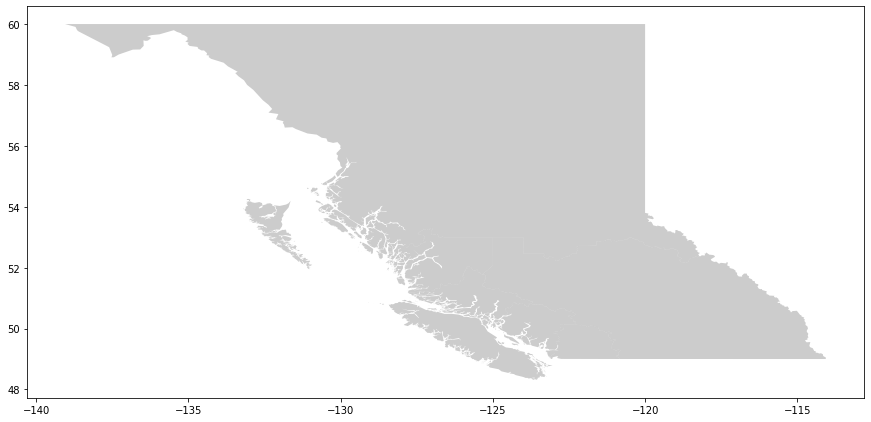

In [64]:
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
            
# geo_df[geo_df['outbreak_status'] == 'yes'].plot(ax = ax, markersize = 16,
#                                                color = 'red', marker = 'o',
#                                                label = "outbreak")
# geo_df[geo_df['outbreak_status'] == 'no'].plot(ax = ax, markersize = 16,
#                                                color = 'blue', marker = 'o',
#                                                label = "no outbreak")
# plt.legend(prop={'size' : 15})